# Eksploracja Danych - Projekt
Tomasz Kiljańczyk (136257)

Wojciech Lulek (136280)

In [19]:
import pandas as pd
from tqdm.notebook import tqdm_notebook

In [20]:
us_trending_df = pd.read_csv('data/us_trending_stage_1.csv')
us_trending_df

,Unnamed: 0,channelId,channelTitle,trending_date,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,...,title_capital_letters,title_punctuaction,description_height,description_length,description_link_count,tag_count,publishedAtHour,publishedAtDay,publishedAtMonth,publishedAtHoliday
0,0,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,2020-08-12,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,...,0.735294,0.088235,7,361,3,15,19,1,8,False
1,1,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,2020-08-12,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,...,0.100000,0.016667,0,715,4,25,17,1,8,False
2,2,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,2020-08-12,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,...,0.094340,0.018868,0,513,7,30,16,1,8,False
3,3,UCbg_UMjlHJg_19SZckaKajg,XXL,2020-08-12,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,...,0.142857,0.017857,5,762,6,23,16,1,8,False
4,4,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,2020-08-12,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,...,0.200000,0.018182,0,2493,35,33,15,1,8,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115386,115386,UCUK0HBIBWgM2c4vsPhkYY4w,The Slow Mo Guys,2022-03-07,981279,70153,0,3845,https://i.ytimg.com/vi/6WUxgmMDts4/default.jpg,False,...,0.142857,0.028571,0,367,2,24,12,1,3,False
115387,115387,UCUaT_39o1x6qWjz7K2pWcgw,Beast Reacts,2022-03-07,7810455,288862,0,8338,https://i.ytimg.com/vi/6-aGt23ytyI/default.jpg,False,...,0.150000,0.050000,0,2101,34,25,21,0,2,False
115388,115388,UCCqEeDAUf4Mg0GgEN658tkA,Chris Stuckmann,2022-03-07,1428477,79929,0,5672,https://i.ytimg.com/vi/vPgrkl7lEjU/default.jpg,False,...,0.160000,0.040000,0,465,2,28,17,0,2,False
115389,115389,UCh529hRsYvu9_Scri20NsHg,Spider,2022-03-07,1378788,8789,0,83,https://i.ytimg.com/vi/6Svr8l1DwTc/default.jpg,False,...,0.000000,0.035714,0,23,0,0,17,1,3,False


In [21]:
us_trending_df['thumbnail_link_hires'] = us_trending_df['thumbnail_link'].str.replace('default.jpg', '0.jpg')
us_trending_df['thumbnail_link_hires']

c:\projects\put\ped\venv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


0         https://i.ytimg.com/vi/3C66w5Z0ixs/0.jpg
1         https://i.ytimg.com/vi/M9Pmf9AB4Mo/0.jpg
2         https://i.ytimg.com/vi/J78aPJ3VyNs/0.jpg
3         https://i.ytimg.com/vi/kXLn3HkpjaA/0.jpg
4         https://i.ytimg.com/vi/VIUo6yapDbc/0.jpg
                            ...                   
115386    https://i.ytimg.com/vi/6WUxgmMDts4/0.jpg
115387    https://i.ytimg.com/vi/6-aGt23ytyI/0.jpg
115388    https://i.ytimg.com/vi/vPgrkl7lEjU/0.jpg
115389    https://i.ytimg.com/vi/6Svr8l1DwTc/0.jpg
115390    https://i.ytimg.com/vi/hBF4TxpTW3Y/0.jpg
Name: thumbnail_link_hires, Length: 115391, dtype: object

In [22]:
from notebooks.workers import download_and_save
from multiprocessing import Pool
import os

if not os.path.exists('images/'):
    os.makedirs('images/')

data = us_trending_df['thumbnail_link_hires'].unique()
with Pool(processes=os.cpu_count()) as pool:
    for _ in tqdm_notebook(pool.imap(download_and_save, data), total=data.size):
        pass


  0%|          | 0/20831 [00:00<?, ?it/s]

In [23]:
from notebooks.workers import extract_hsv_features
from PIL import Image

image_dataframe = pd.DataFrame(columns=[
    'thumbnail_med_hue',
    'thumbnail_med_saturation',
    'thumbnail_med_value'
])

data = us_trending_df['thumbnail_link_hires'].unique()
results = []
with Pool(processes=os.cpu_count()) as pool:
    for res in tqdm_notebook(pool.imap(extract_hsv_features, data), total=data.size):
        results.append(res)

hsv_features_dict = dict(results)

hsv_features = [hsv_features_dict[url] for url in us_trending_df['thumbnail_link_hires']]

image_dataframe = image_dataframe.append(hsv_features, ignore_index=True)
image_dataframe

  0%|          | 0/20831 [00:00<?, ?it/s]

,thumbnail_med_hue,thumbnail_med_saturation,thumbnail_med_value
0,21.0,43.0,221.0
1,14.0,170.0,77.0
2,12.0,98.0,131.0
3,29.0,67.0,152.0
4,16.0,82.0,178.0
...,...,...,...
115386,0.0,0.0,2.0
115387,19.0,70.0,189.0
115388,22.0,131.0,97.0
115389,108.0,70.0,253.0


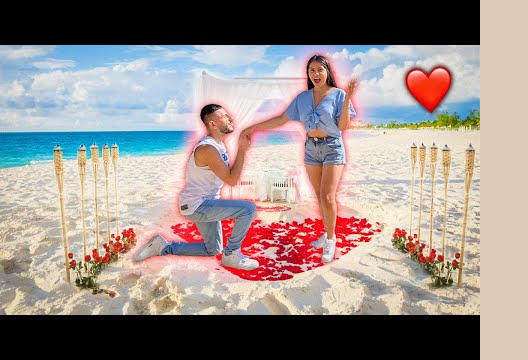

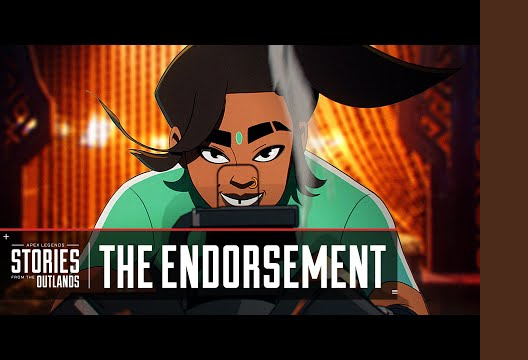

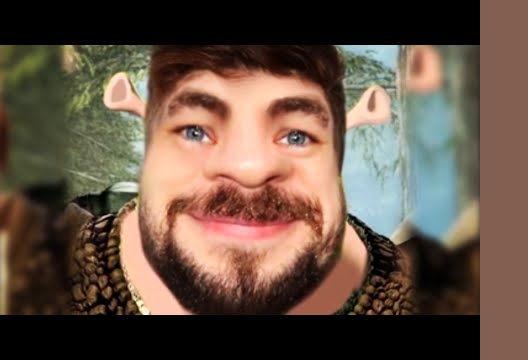

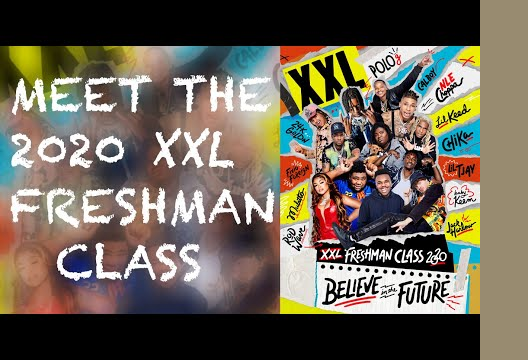

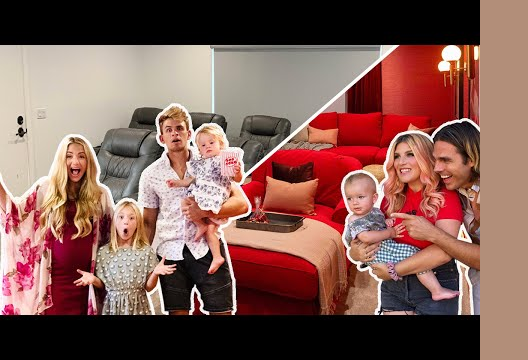

In [24]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


for i, url in enumerate(us_trending_df['thumbnail_link_hires'].head(5)):
    file_path = f'./images/{url.split("/")[-2]}.jpg'

    image = Image.open(file_path)

    row = image_dataframe.iloc[i]
    hsv_color = (
        round(row['thumbnail_med_hue']),
        round(row['thumbnail_med_saturation']),
        round(row['thumbnail_med_value'])
    )
    dims = (round(image.width * 0.1), image.height)
    avg_color_image = Image.new('HSV', dims, color=hsv_color).convert('RGB')

    display(get_concat_h(image, avg_color_image))

In [25]:
from notebooks.workers import detect_text

results = []
with Pool(processes=os.cpu_count()) as pool:
    data = us_trending_df['thumbnail_link_hires'].unique()
    for res in tqdm_notebook(pool.imap(detect_text, data), total=data.size):
        results.append(res)

has_text_dict = dict(results)
has_text = [has_text_dict.get(url, False) for url in us_trending_df['thumbnail_link_hires']]

  0%|          | 0/537 [00:00<?, ?it/s]

In [26]:
has_text_df = pd.DataFrame(has_text, columns=['has_text'])
has_text_df

,has_text
0,True
1,True
2,False
3,True
4,False
...,...
115386,False
115387,False
115388,False
115389,False
